##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

In [2]:
# prompt: kiểm tra version của mediapipe

import mediapipe as mp

mp.__version__


'0.10.21'

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [3]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [4]:
import math
import numpy as np
def calculate_angle(a, b, c):
    # Tính vector AB và BC
    ab = (b.x - a.x, b.y - a.y)
    ac = (c.x - a.x, c.y - a.y)

    # Tính tích vô hướng và độ dài của các vector
    dot_product = ab[0] * ac[0] + ab[1] * ac[1]
    magnitude_ab = math.sqrt(ab[0]**2 + ab[1]**2)
    magnitude_ac = math.sqrt(ac[0]**2 + ac[1]**2)

    # Tính góc giữa hai vector (đơn vị radian)
    angle = math.acos(dot_product / (magnitude_ab * magnitude_ac))

    # Chuyển đổi sang độ
    return math.degrees(angle)



def count_fingers(hand_landmarks):
  """Counts the number of fingers extended based on hand landmarks."""
  try:
    wrist = hand_landmarks[mp.solutions.hands.HandLandmark.WRIST]
    finger_tips = [
        hand_landmarks[mp.solutions.hands.HandLandmark.INDEX_FINGER_TIP],
        hand_landmarks[mp.solutions.hands.HandLandmark.MIDDLE_FINGER_TIP],
        hand_landmarks[mp.solutions.hands.HandLandmark.RING_FINGER_TIP],
        hand_landmarks[mp.solutions.hands.HandLandmark.PINKY_TIP]
    ]

    finger_pips = [
        hand_landmarks[mp.solutions.hands.HandLandmark.INDEX_FINGER_PIP],
        hand_landmarks[mp.solutions.hands.HandLandmark.MIDDLE_FINGER_PIP],
        hand_landmarks[mp.solutions.hands.HandLandmark.RING_FINGER_PIP],
        hand_landmarks[mp.solutions.hands.HandLandmark.PINKY_PIP]
    ]

    thumb_cmc = hand_landmarks[mp.solutions.hands.HandLandmark.THUMB_CMC]
    thumb_mcp = hand_landmarks[mp.solutions.hands.HandLandmark.THUMB_MCP]
    thumb_ip = hand_landmarks[mp.solutions.hands.HandLandmark.THUMB_IP]
    thumb_tip = hand_landmarks[mp.solutions.hands.HandLandmark.THUMB_TIP]

  except:
    return None
  count = 0
  for tip, pip in zip(finger_tips, finger_pips):
    angle = calculate_angle(pip, wrist, tip)
    if angle > 130:
      count += 1

  angle_thumb = calculate_angle(wrist, thumb_cmc, thumb_tip)
  if angle_thumb < 30:
    count += 1
  return count

## Visualization utilities

In [5]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    if count_fingers(hand_landmarks) is not None:
    # Draw handedness (left or right hand) on the image.
      cv2.putText(annotated_image, f"{handedness[0].category_name}: {count_fingers(hand_landmarks)}",
                  (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                  FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)
    else:
      cv2.putText(annotated_image, f"{handedness[0].category_name}:?",
                  (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                  FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

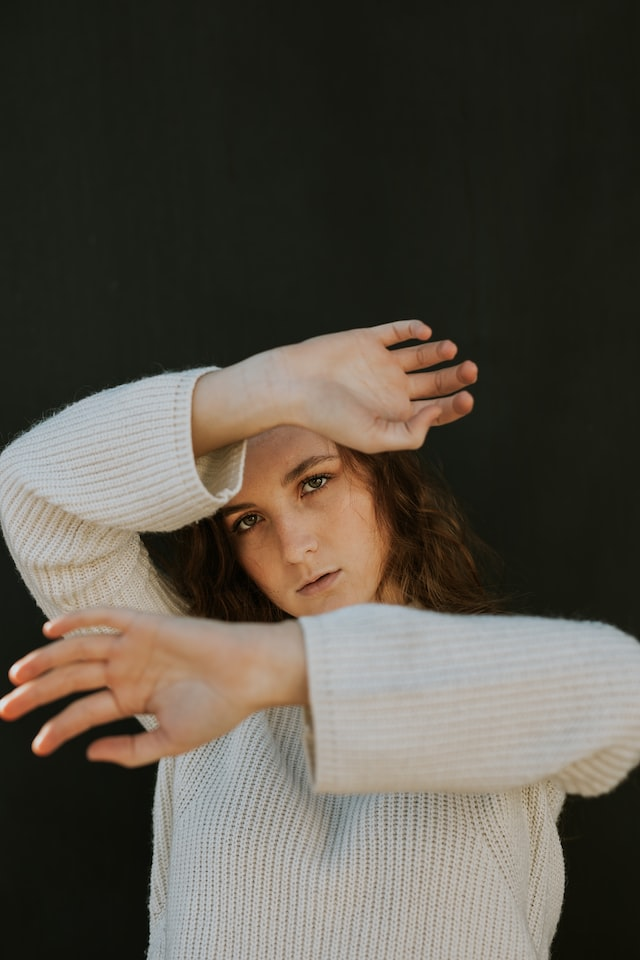

In [6]:
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


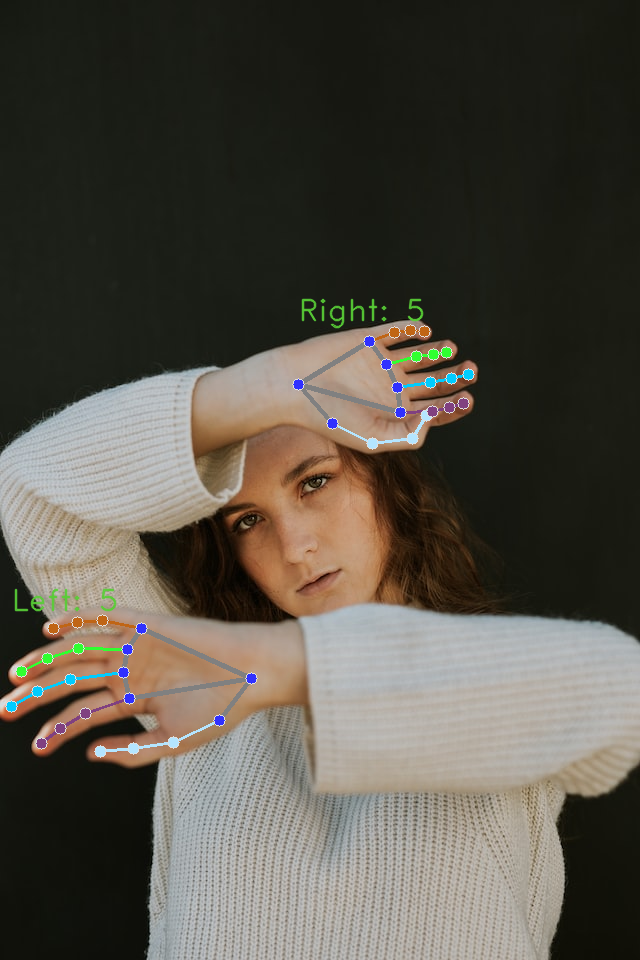

In [7]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Open video file
video_path = "hand.mp4"  # Replace with your video file path
capture = cv2.VideoCapture(video_path)

# Check if the video file opened successfully
if not capture.isOpened():
    print("Error opening video file.")
    exit()

# Get video properties
frame_width = int(capture.get(3))
frame_height = int(capture.get(4))
fps = int(capture.get(cv2.CAP_PROP_FPS))

# Define codec and create VideoWriter
output_path = "output_count_fingers.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))


while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        break

    # Convert the frame from BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert frame to mediapipe format
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # Detect pose landmarks
    detection_result = detector.detect(mp_image)

    # Draw landmarks
    annotated_frame = draw_landmarks_on_image(frame_rgb, detection_result)

    # Convert the annotated frame back to BGR
    annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    # Write processed frame to output video
    out.write(annotated_frame_bgr)

# Release resources
capture.release()
out.release()